In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set(font_scale=1)

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

In [13]:
df_train = pd.read_csv('train_splitted.csv')

# df_train = pd.read_csv('train.csv')

In [14]:
def augment(x,y,ones_t=2, zeros_t=1):
    xs,xn = [],[]
    for i in range(ones_t):
        x1 = x[y==1].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[:,c][ids]
        xs.append(x1)

    for i in range(zeros_t):
        x1 = x[y==0].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[:,c][ids]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [15]:
lgb_params = {
    "device": "gpu",
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : random_state,
    "verbosity" : 1,
    "seed": random_state
}

# K-folding

In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
oof = df_train[['ID_code', 'target']]
oof['predict'] = 0
predictions = df_test[['ID_code']]
val_aucs = []
feature_importance_df = pd.DataFrame()

In [17]:
features = [col for col in df_train.columns if col not in ['target', 'ID_code']]
X_test = df_test[features].values

In [ ]:
for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train, df_train['target'])):
    X_train, y_train = df_train.iloc[trn_idx][features], df_train.iloc[trn_idx]['target']
    X_valid, y_valid = df_train.iloc[val_idx][features], df_train.iloc[val_idx]['target']
    
    N = 5
    p_valid,yp = 0,0
    for i in range(N):
        X_t, y_t = augment(X_train.values, y_train.values, ones_t=2, zeros_t=1)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        100000,
                        valid_sets = [trn_data, val_data],
                        early_stopping_rounds=3000,
                        verbose_eval = 1000,
                        evals_result=evals_result
                       )
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = lgb_clf.feature_importance()
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    oof['predict'][val_idx] = p_valid/N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
    predictions['fold{}'.format(fold+1)] = yp/N

Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.894861	valid_1's auc: 0.882508
[2000]	training's auc: 0.904174	valid_1's auc: 0.889398
[3000]	training's auc: 0.910741	valid_1's auc: 0.893769
[4000]	training's auc: 0.915852	valid_1's auc: 0.89661
[5000]	training's auc: 0.919879	valid_1's auc: 0.898233
[6000]	training's auc: 0.923356	valid_1's auc: 0.899105
[7000]	training's auc: 0.926425	valid_1's auc: 0.899456
[8000]	training's auc: 0.929243	valid_1's auc: 0.899743
[9000]	training's auc: 0.931887	valid_1's auc: 0.899754
[10000]	training's auc: 0.934411	valid_1's auc: 0.899616
[11000]	training's auc: 0.936896	valid_1's auc: 0.899567
Early stopping, best iteration is:
[8205]	training's auc: 0.929799	valid_1's auc: 0.899781
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.894587	valid_1's auc: 0.88242
[2000]	training's auc: 0.903717	valid_1's auc: 0.889092
[3000]	training's auc: 0.910262	valid_1's auc: 0.8936

In [19]:
1

1

In [22]:
predictions.to_csv('lgbm_predictions', index_label=False)

In [20]:
import pickle
with open('lgmb_model_train_only.pkl', 'wb') as fout:
    pickle.dump(lgb_clf, fout)

In [17]:
lgb_clf.save_model('lgbm.txt')

In [63]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.901528341, std: 0.003076874. All auc: 0.901502626.


In [9]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.901706571, std: 0.003082692. All auc: 0.901683607.


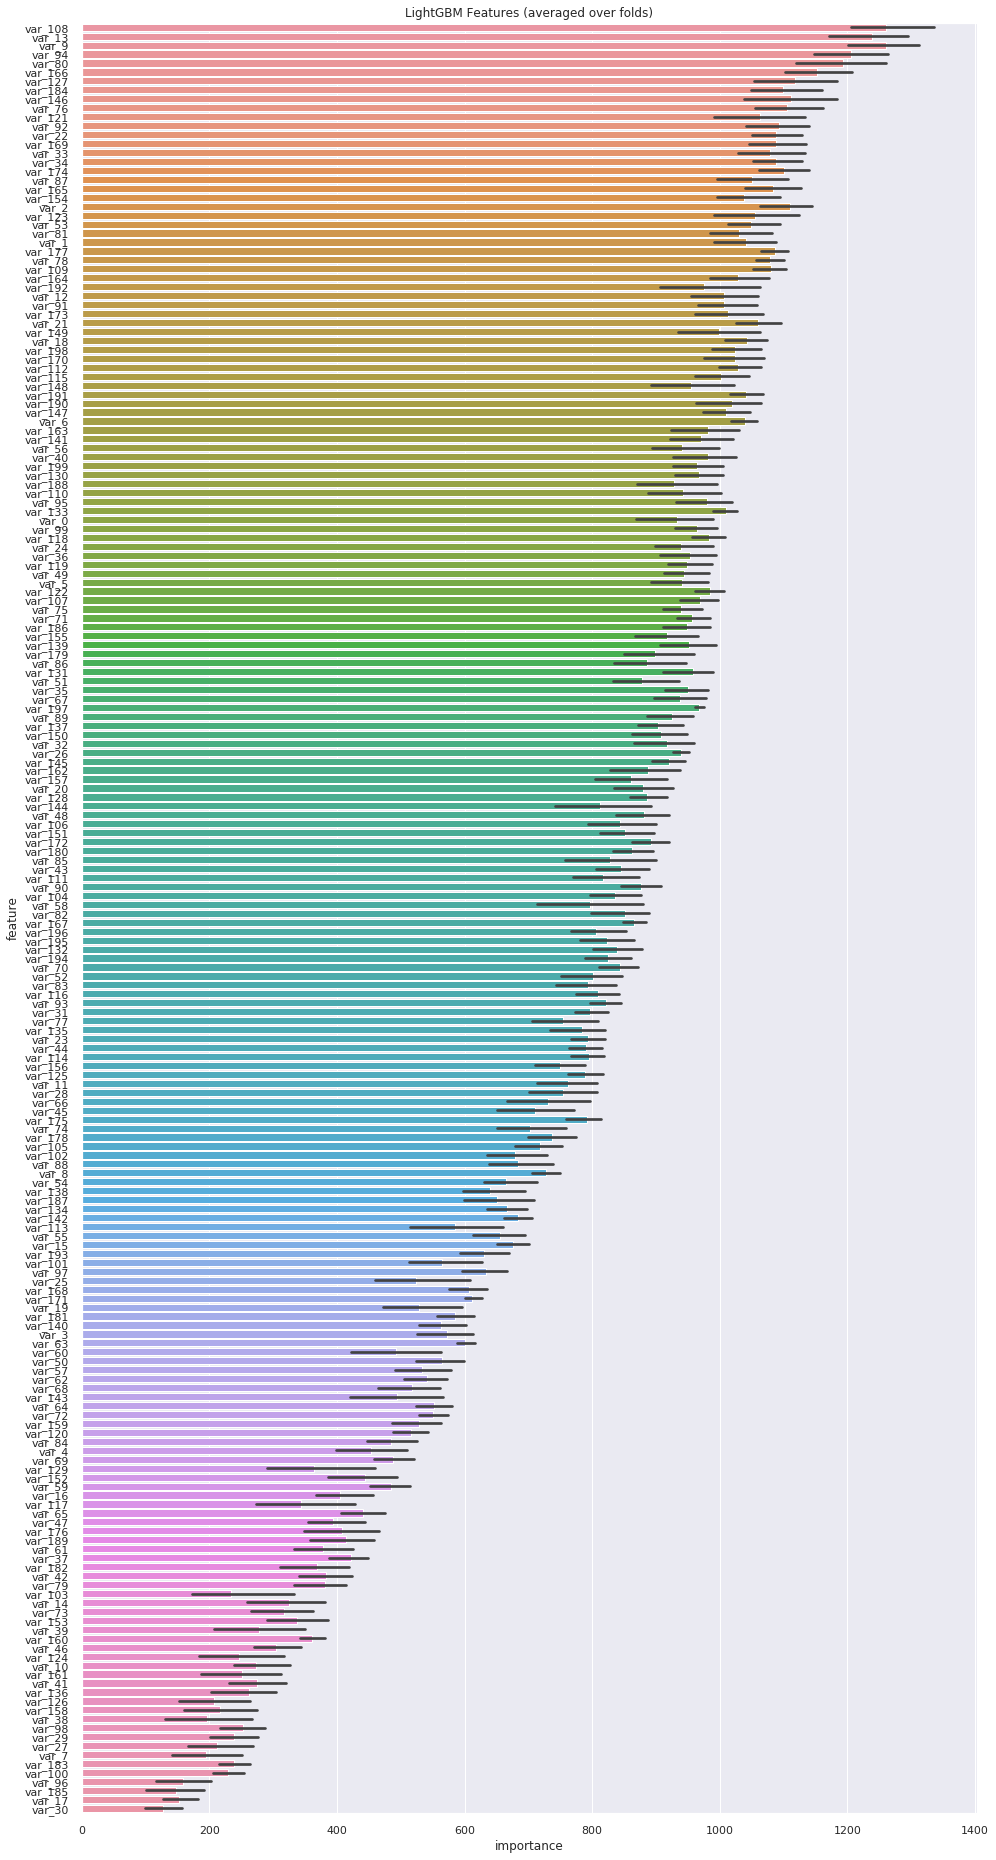

In [64]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [69]:
filename = "lgb_submission_1.csv"

In [65]:
# submission
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
predictions.to_csv('lgb_all_predictions.csv', index=None)
sub_df = pd.DataFrame({"ID_code":df_test["ID_code"].values})
sub_df["target"] = predictions['target']
sub_df.to_csv(filename, index=False)
oof.to_csv('lgb_oof.csv', index=False)

In [70]:
! kaggle competitions submit -c santander-customer-transaction-prediction -f {filename} -m "lgb_submission"

100%|███████████████████████████████████████| 5.98M/5.98M [00:19<00:00, 315kB/s]
Successfully submitted to Santander Customer Transaction Prediction